In [ ]:
# TODO : -----

# using TF-IDF remove word that appear in many doc -> un-important to indicate topics 
# coherrence of doc
# phân biệt LDA, ProdLDA 
# ADDING seeded list  

In [ ]:
! pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 21.6 MB/s 
     |████████████████████████████████| 581 kB 64.2 MB/s 
     |████████████████████████████████| 965 kB 72.0 MB/s 
     |████████████████████████████████| 235 kB 81.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
# from torchvision import datasets
# from torchvision import transforms
import matplotlib.pyplot as plt 
torch.manual_seed(1)  

import re 



from underthesea import word_tokenize 

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer



In [ ]:
!gdown --id 1-1bZDGeY5n5VpNdQBxLgFdxqVf4OqRJy 

df = pd.read_csv('/content/vietnews-master-2.csv') 
print(df.shape)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-1bZDGeY5n5VpNdQBxLgFdxqVf4OqRJy
To: /content/vietnews-master-2.csv
100% 3.45M/3.45M [00:00<00:00, 318MB/s]
(999, 2)


In [ ]:
# !gdown --id 1xXCOcR8hDXhtYxpgN76lGzT0ZMYOKArU 

# df = pd.read_csv('/content/vietnews-master-3.csv')
# print(df.shape)

(999, 2)

In [ ]:
https://drive.google.com/file/d/1MhYgIQasTFUkQFtTOxssZUuVGtiWlwGM/view?usp=sharing 

In [ ]:
def clean_text(text):
    t = re.sub("\n|\r|\xa0|;|,|(.-)|\.|\(|\)|:|\'|\"|\*"," ",text)
    return t.strip().lower()
  
def tokenizing(text):
    txt = re.sub("\n|\r|\xa0|;|,|(.-)|\.|\(|\)|:|\'|\"|\*"," ",text).lower()
    result = word_tokenize(txt.lower())
    return result #[i for i in txt.split(" ")]

def clean_enter_newline(text):
  return ' '.join(text.split('\n'))

def tokenizing_2(text, stopwords):
    # text = re.sub("\n|\r|\xa0|;|,|(.-)|\.|\(|\)|:|\'|\"|\*"," ",text) 
    # return [i for i in text.split(" ") if i not in stopwords and i != '']
    text = re.sub("\n|\r|\xa0|;|,|(.-)|\.|\(|\)|:|\'|\"|\*"," ",text).lower() 
    text = word_tokenize(text.lower())
    return [i for i in text if i not in stopwords] 
    # return [i for i in text.replace("\n", " ").split(" ") if i not in stopwords] 

In [ ]:
# !gdown --id 1OjWsl_1EDVx9E2efLSNcvNmSUuXjINwl # 2 
!gdown --id 1MhYgIQasTFUkQFtTOxssZUuVGtiWlwGM 


sw = pd.read_csv("/content/stopwords_2.csv") 
sw['len'] = sw['word'].apply(lambda x: len(str(x).split('_'))) 
choosen = sw[(sw['len']==1) & (sw['tf_idf'] <=0.25)] 

stopwords = dict.fromkeys(choosen["word"].tolist(), 1)
# df['content_clean'] = df['content'].apply(lambda x: ' '.join(tokenizing_2(x.lower(), stopwords))) 
print(len(stopwords))


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MhYgIQasTFUkQFtTOxssZUuVGtiWlwGM
To: /content/stopwords_2.csv
100% 11.1M/11.1M [00:00<00:00, 229MB/s]
10597


In [ ]:
df['content_clean'] = df['content'].apply(lambda x: ' '.join(tokenizing_2(x.lower(), stopwords)))  

In [ ]:
vectorizer = CountVectorizer(max_features = 500, max_df=0.5, min_df=20)
docs = torch.from_numpy(vectorizer.fit_transform(df['content_clean']).toarray()).float()

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index 

In [ ]:
docs_loader = torch.utils.data.DataLoader(
    dataset=docs.float(), 
    batch_size=32,
    shuffle=True)  

In [ ]:
print(docs.shape)

torch.Size([999, 500])


In [ ]:
def prior(topics): 
    """
    Prior for the model.
    :param topics: number of topics
    :return: mean and variance tensors
    """
    a = torch.Tensor(1, topics).float().fill_(1.0)
    mean = a.log().t() - a.log().mean(1)
    var = ((1 - 2.0 / topics) * a.reciprocal()).t() + (
        1.0 / topics ** 2
    ) * a.reciprocal().sum(1)
    return mean.t(), var.t() 

class Encoder(nn.Module):
  def __init__(self, vocab_size, hidden, num_topics, dropout):
    super().__init__()
    self.num_topics = num_topics 
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(vocab_size, hidden)
    self.sp1 = nn.Softplus()
    self.fc2 = nn.Linear(hidden, num_topics * 2)
    self.sp2 = nn.Softplus()

    self.bnorm_mu = nn.BatchNorm1d(num_topics) 
    self.bnorm_var = nn.BatchNorm1d(num_topics) 


  def forward(self, X):
    h = self.sp1(self.fc1(X))
    h = self.sp2(self.fc2(h))

    h = self.dropout(h)

    h = h.view(-1, 2, self.num_topics)
    mu = self.bnorm_mu(h[:, 0, :]) 
    log_var = self.bnorm_var(h[:, 1, :])
    
    return mu, log_var # deterministic 

class Decoder(nn.Module):
  def __init__(self, vocab_size, num_topics, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)  
    self.beta= nn.Linear(num_topics, vocab_size, bias=False)  # weight of this is Beta Matrix -> latent space cua topic  | OR this is distribution over vocab of each topic 
    self.bn = nn.BatchNorm1d(vocab_size, affine=False)

  def forward(self, gauss_z):
    x = self.dropout(gauss_z)
    x = self.bn(self.beta(x)) # [topics, hidden] 
    return  F.softmax(x, dim=1) # [docs(batch) , Beta_vector ] (beta_vector = vocab)

# ---------------------------------------------------------------- 
class ProdLDA(nn.Module):  
  def __init__(self, vocab_size, hidden, num_topics, dropout): 
    super().__init__()
    self.num_topics = num_topics
    # ------- 
    self.encoder = Encoder(vocab_size, hidden, num_topics, dropout)
    self.decoder = Decoder(vocab_size, num_topics, dropout)

    # del ------ 
    self.prior_mean, self.prior_var = map(nn.Parameter, prior(num_topics))
    self.prior_logvar = nn.Parameter(self.prior_var.log())
    self.prior_mean.requires_grad = False
    self.prior_var.requires_grad = False
    self.prior_logvar.requires_grad = False 


  @staticmethod 
  def reparameterize(mu, log_var): 
    std = torch.exp(0.5 * log_var) 
    eps = torch.rand_like(std) # uniform 
    return mu + (eps * std) 

  def forward(self, X, encoding=True):
    if encoding == True:
      mu, log_var = self.encoder(X)
    else: 
      mu, log_var = X[0], X[1]

    gauss_z = self.reparameterize(mu, log_var) # sampling_Normal distribution  
    dir_z = F.softmax(gauss_z, dim=1) #note: Multinormial ( not dir_z):  Z_{n} size = (batch, theta_vector=topics numbers) or we called theta_vector | Multinormial distribution have parameter = gausian 
     
    reconstr = self.decoder(dir_z)
    return reconstr , mu, log_var, gauss_z, dir_z

  def beta(self):
      return self.decoder.beta.weight.detach().T 

# del ----- 
  def loss(self, x, reconstruction, posterior_mean, posterior_logvar): 
    
    # Beause the p(x| alpha, beta ) is multinormial distribution -> use negative log likelihood loss 
    reconstr_negative_llh = -(F.softmax(x) * (reconstruction+(1e-10)).log()).sum(-1) # x * reconstruction = nll - [(y_i)log(p_i) + (y_i-1)log(1-p_i) neu co 2 lop 

    prior_mean = self.prior_mean.expand_as(posterior_mean)
    prior_var = self.prior_var.expand_as(posterior_logvar)
    prior_logvar = self.prior_logvar.expand_as(posterior_logvar)
    var_division = posterior_logvar.exp() / prior_var

    diff = posterior_mean - prior_mean
    diff_term = diff * diff / prior_var
    logvar_division = prior_logvar - posterior_logvar
    kld = 0.5 * ((var_division + diff_term + logvar_division).sum(1) - self.num_topics)

    return  reconstr_negative_llh + kld 

In [ ]:
vocab_size = vocab.shape[0] 
num_topics = 6
model = ProdLDA(vocab_size, 200, num_topics, 0.3)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = 0.002
)  

epochs = 20
losses = [] 
outputs = [] 
div_z_outputs = []

for epoch in range(epochs):
  for data in docs_loader:
    
    (reconstruction, mu, log_var, gauzz_z, div_z) = model(data)

    ls = model.loss(data, reconstruction, mu, log_var) 
    loss = ls.mean()
    losses.append(loss.item())

    outputs.append(reconstruction)
    div_z_outputs.append(div_z)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step(closure=None)

  print('Epoch {: 2} | Train Loss: {:10.8f}'.format(epoch, loss))  
  # print('Epoch {: 2} | Train Loss: {:10.8f}| Recon-Loss {:10.8}| KL-Loss {:10.8}'.format(epoch, loss, rl.mean().item(), kld.mean().item() )) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  0 | Train Loss: 10.80951786
Epoch  1 | Train Loss: 10.33936405
Epoch  2 | Train Loss: 9.21980953
Epoch  3 | Train Loss: 8.97125340
Epoch  4 | Train Loss: 8.65071392
Epoch  5 | Train Loss: 7.86172247
Epoch  6 | Train Loss: 7.96369076
Epoch  7 | Train Loss: 7.92633295
Epoch  8 | Train Loss: 7.19347906
Epoch  9 | Train Loss: 7.15308523
Epoch  10 | Train Loss: 7.21878910
Epoch  11 | Train Loss: 6.87223959
Epoch  12 | Train Loss: 7.21538496
Epoch  13 | Train Loss: 7.08192539
Epoch  14 | Train Loss: 6.81278896
Epoch  15 | Train Loss: 6.22579575
Epoch  16 | Train Loss: 6.35637426
Epoch  17 | Train Loss: 6.72326183
Epoch  18 | Train Loss: 6.41151667
Epoch  19 | Train Loss: 6.82863188


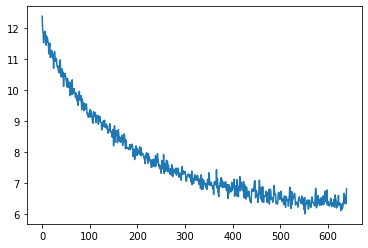

In [ ]:
plt.plot([i for i in losses])

In [ ]:
def get_topic_dict(beta, number_of_topwords, num_topics):  
  
  _dict_topic2topword = {}
  for n in range(num_topics):
    b = beta[n]
    sorted_, indices = torch.sort(b, descending=True)
    
    tmp = pd.DataFrame(indices[: number_of_topwords].numpy(), columns=['index'])
    w = pd.merge(tmp, vocab[['index', 'word']],how='left', on='index')['word'].values.tolist()
    _dict_topic2topword.update({n : w})
  return _dict_topic2topword  


def calc_coocurrence_words_corpus(docs, vocab): 
  # vocab = vocab_df 
  non_zeros_mark = docs>0 
  non_zeros_doc = torch.nonzero(non_zeros_mark)
  non_zeros_doc.shape
  
  count_df = pd.DataFrame(non_zeros_doc.numpy(), columns= ['doc_idx', 'vocab_id']) 

  self_join_df = pd.merge(count_df, count_df, how = 'left', on = 'doc_idx') 
  self_join_df = self_join_df.rename(columns = {'vocab_id_x': 'vocab_id_1','vocab_id_y': 'vocab_id_2'})
  self_join_df = self_join_df[self_join_df['vocab_id_1'] <  self_join_df['vocab_id_2']]

  count_docs = self_join_df.groupby(['vocab_id_1', 'vocab_id_2'], as_index=False)['doc_idx'].count().rename(columns={'doc_idx':'co_occur'}).reset_index() 
  count_docs = count_docs.drop(columns=['index'])
  count_docs = pd.merge(
      count_docs, 
      count_df.groupby(['vocab_id'])['doc_idx'].count().to_frame().rename(columns={'doc_idx':'vocab_1_count'}).reset_index(),
      how  ='left', 
      left_on = 'vocab_id_2', right_on='vocab_id'
  ).drop(columns = ['vocab_id'])
  count_docs = pd.merge(
      count_docs, 
      count_df.groupby(['vocab_id'])['doc_idx'].count().to_frame().rename(columns={'doc_idx':'vocab_2_count'}).reset_index(),
      how  ='left', 
      left_on = 'vocab_id_2', 
      right_on='vocab_id'
  ).drop(columns = ['vocab_id'])
  count_docs['total_docs'] = docs.shape[0]

  count_docs = pd.merge(count_docs, vocab[['index', 'word']],
                    how='left', left_on='vocab_id_1', right_on='index').drop(columns=['index']).rename(columns={'word':'word_1'})
  count_docs = pd.merge(count_docs, vocab[['index', 'word']],
                    how='left', left_on='vocab_id_2', right_on='index').drop(columns=['index']).rename(columns={'word':'word_2'})
  # https://en.wikipedia.org/wiki/Pointwise_mutual_information#:~:text=Similarities%20to%20mutual%20information%5Bedit%5D 
  from math import log 
  h = lambda u: -log(u/docs.shape[0],2)  
  count_docs['pmi']=count_docs.apply(lambda x: h(x['vocab_1_count']) + h(x['vocab_2_count']) - h(x['co_occur']),axis=1) 
  count_docs['npmi']=count_docs.apply(lambda x: (h(x['vocab_1_count']) + h(x['vocab_2_count']) - h(x['co_occur'])) / h(x['co_occur']),axis=1) 
  return count_docs 


def calc_topic_coherence(_dict_topic2topword, coocurrence_df,  metrics = 'npmi'): 
  df = pd.DataFrame([])
  for topic_idx, w in _dict_topic2topword.items():
    _tmp = pd.DataFrame(w, columns=["words"])
    _tmp = pd.merge(_tmp, vocab[['index', 'word']],
                      how='left', left_on='words', right_on='word').drop(columns=['word'])
    _tmp['topic_number'] = topic_idx 
    df = pd.concat([df, _tmp])
  df = df.sort_values(by=['topic_number', 'index']) 
  self_join = pd.merge(df, df[['topic_number', 'index']], 
                     how = 'left', on=['topic_number']).rename(columns={'index_x': 'index_1', 'index_y': 'index_2'})
  self_join = self_join[self_join['index_1'] < self_join['index_2']]
  if metrics == 'npmi': 
    self_join = pd.merge(
                        self_join, coocurrence_df[['vocab_id_1', 'vocab_id_2','npmi']], 
                        how = 'left', 
                        left_on = ['index_1', 'index_2'], 
                        right_on = ['vocab_id_1', 'vocab_id_2']
                        ).drop(columns=['vocab_id_1', 'vocab_id_2'])
    mean_df = self_join.groupby(['topic_number'])['npmi'].mean().reset_index() 
    mean =  mean_df['npmi'].mean()
  else:
    self_join = pd.merge(
                        self_join, coocurrence_df[['vocab_id_1', 'vocab_id_2','pmi']], 
                        how = 'left', 
                        left_on = ['index_1', 'index_2'], 
                        right_on = ['vocab_id_1', 'vocab_id_2']
                        ).drop(columns=['vocab_id_1', 'vocab_id_2'])
  
    mean_df = self_join.groupby(['topic_number'])['pmi'].mean().reset_index() 
    mean =  mean_df['pmi'].mean()

  return mean_df.to_dict(), mean


def run_coherence_calc(docs, vocab, number_of_topwords, metrics = 'npmi'):  # npmi  or pmi 
  _dict_topic2topword = get_topic_dict(beta, number_of_topwords, num_topics) 
  coocurrence_df = calc_coocurrence_words_corpus(docs, vocab)
  each_topics, result = calc_topic_coherence(_dict_topic2topword, coocurrence_df,  metrics = metrics) 
  return each_topics, result  

num_topics: 6


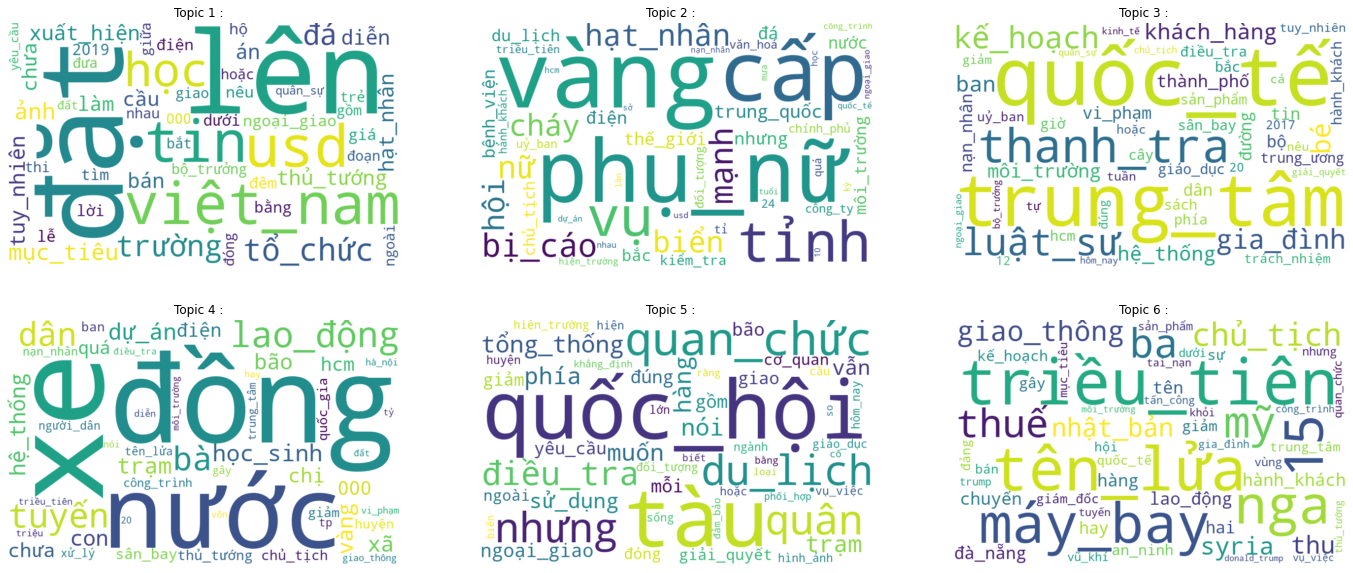

In [ ]:
top_n_words = 50
def plot_word_cloud(b, ax, v, n, topic_name):
  sorted_, indices = torch.sort(b, descending=True)
  df = pd.DataFrame(indices[:top_n_words].numpy(), columns=['index'])
  words = pd.merge(df, vocab[['index', 'word']],
                    how='left', on='index')['word'].values.tolist()
  # print(words)
  sizes = (sorted_[:top_n_words] * 1000).int().numpy().tolist()
  freqs = {words[i]: sizes[i] for i in range(len(words))}
  # print(sizes)
  wc = WordCloud(background_color="white", width=800, height=500)
  wc = wc.generate_from_frequencies(freqs)
  ax.set_title('Topic {} :  {}'.format(n+1, topic_name))
  ax.imshow(wc, interpolation='bilinear')
  ax.axis("off")

import matplotlib.pyplot as plt
from wordcloud import WordCloud


print('num_topics:', num_topics)
beta = model.beta()
per_row = 3
fig, axs = plt.subplots(2, per_row, figsize=(24, 10)) # 2 perrow 
# fig, axs = plt.subplots(7, 3, figsize=(14, 24))
for n in range(0, num_topics): 
    i, j = divmod(n, per_row)

    plot_word_cloud(beta[n], axs[i, j], vocab, n, " ")

axs[-1, -1].axis('off');

plt.show()

# Calculate Topic Coherence

In [ ]:
 each_topics, result  = run_coherence_calc(docs, vocab, 50, metrics = 'npmi')
 print('Coherence (NPMI) is:', result)

Coherence (NPMI) is: 0.031541044712505524


In [ ]:
for idx, i in enumerate(div_z_outputs[0][0:10,:]):
  print('topic of document number {} is {}'.format(
      idx, 
      torch.argmax(i).item())
  )

topic of document number 0 is 5
topic of document number 1 is 3
topic of document number 2 is 1
topic of document number 3 is 4
topic of document number 4 is 1
topic of document number 5 is 3
topic of document number 6 is 1
topic of document number 7 is 0
topic of document number 8 is 0
topic of document number 9 is 1
